In \[1\]:

    import pandas as pd
    import numpy as np
    import json
    import os


    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.decomposition import PCA

    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import plot_confusion_matrix
    import seaborn as sn


    from matplotlib import pyplot as plt
    from PIL import Image




    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F
    import torch.optim as optim
    import torchvision.models as models
    from torchvision import datasets, transforms
    from torchinfo import summary

    import pkbar
    from collections import OrderedDict
    import copy
    import rasterio as rs
    from rasterio import plot

In \[2\]:

    dioni_data = rs.open("./HyRANK_satellite/TrainingSet/Dioni.tif").read()
    dioni_labels = rs.open("./HyRANK_satellite/TrainingSet/Dioni_GT.tif").read()

    loukia_data = rs.open("./HyRANK_satellite/TrainingSet/Loukia.tif").read()
    loukia_labels = rs.open("./HyRANK_satellite/TrainingSet/Loukia_GT.tif").read()

    /home/christos/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
      s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)

In \[3\]:

    print(dioni_data.shape)
    print(loukia_data.shape)

    (176, 250, 1376)
    (176, 249, 945)

RGB - R:23, G:11, B:07

In \[4\]:

    plt.figure(figsize=(40,15))
    plt.imshow(np.transpose(dioni_labels, (1, 2, 0)))

    plt.figure(figsize=(40,15))
    plt.imshow(np.transpose(loukia_labels, (1, 2, 0)))

Out\[4\]:

    <matplotlib.image.AxesImage at 0x7fc50b090190>

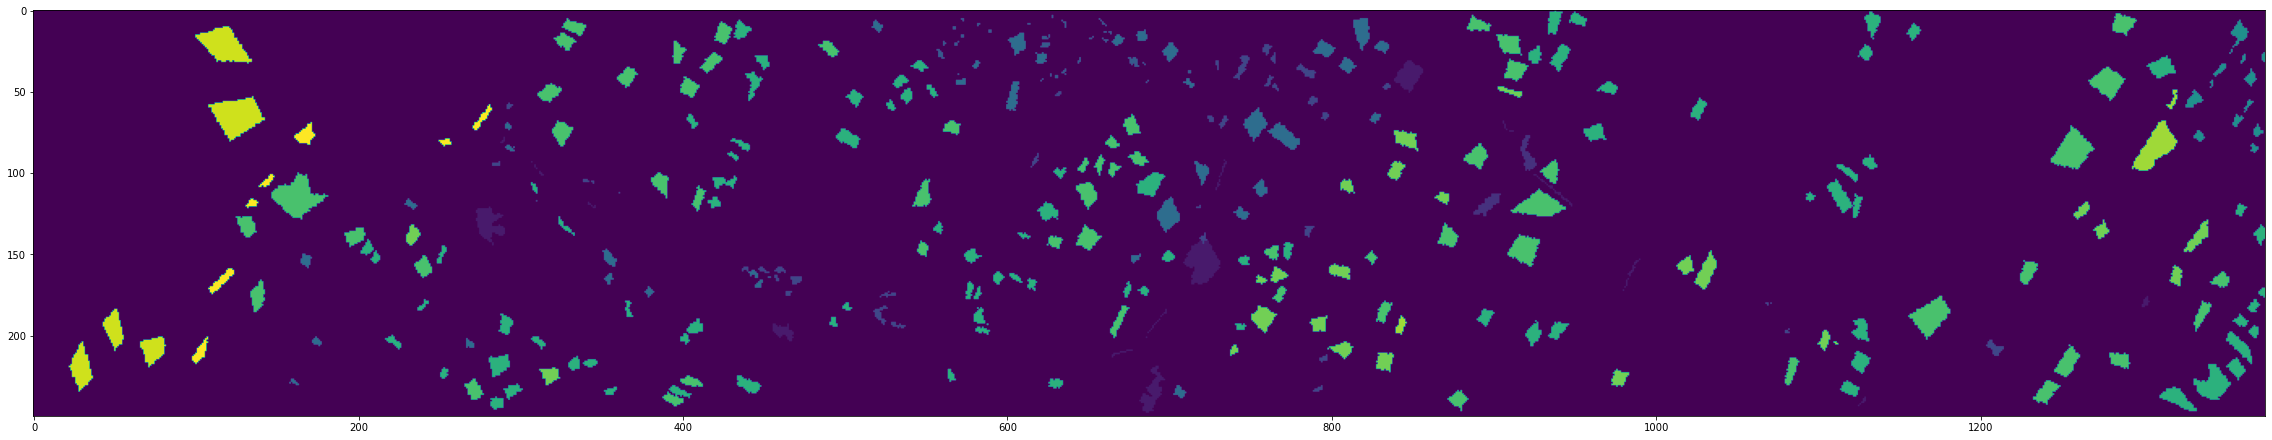

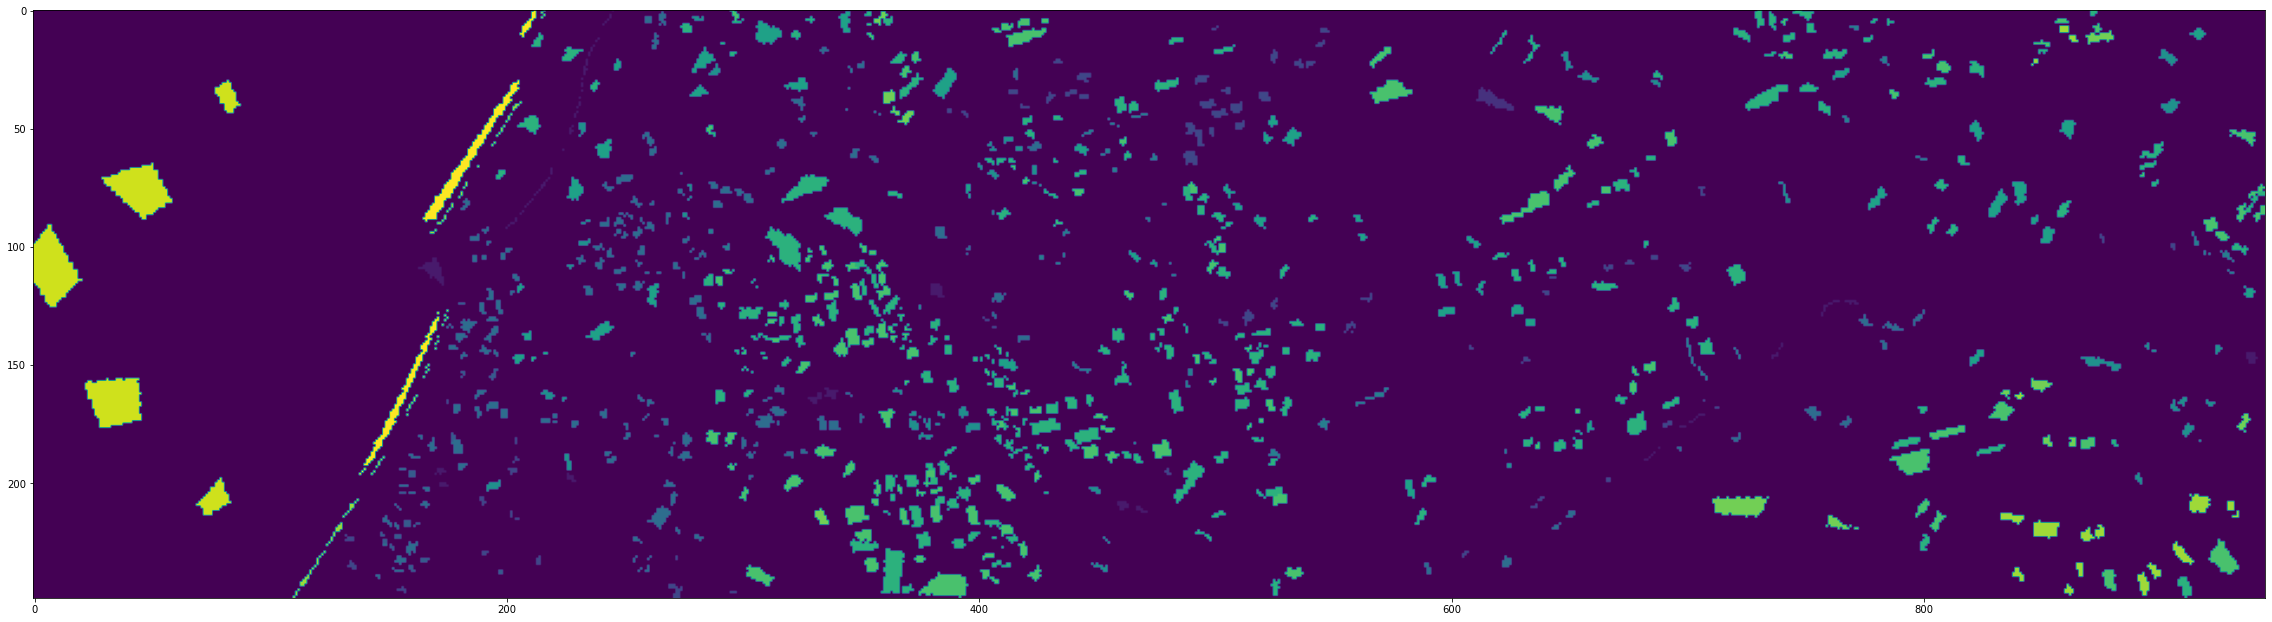

In \[9\]:

    plt.figure(figsize=(40,15))
    plot.show(dioni_data[123])

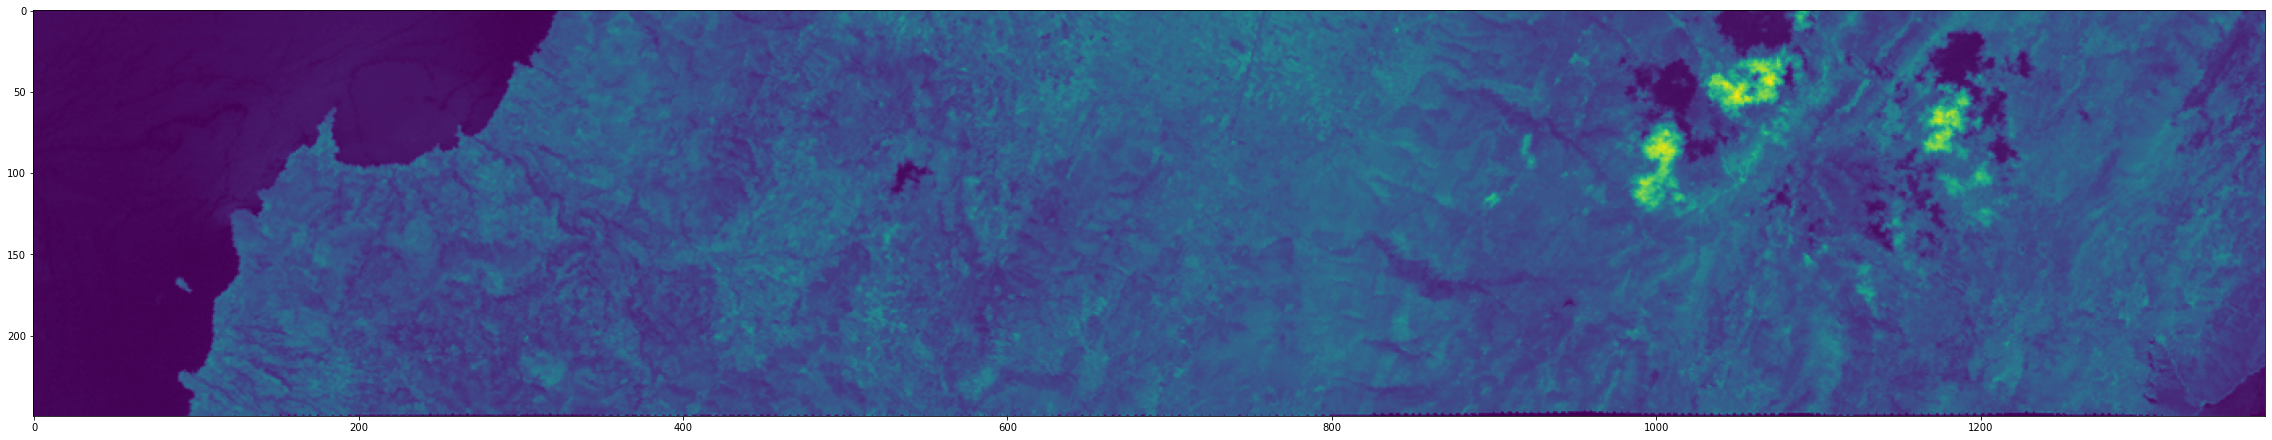

Out\[9\]:

    <AxesSubplot:>

In \[18\]:

    #dioni
    r = np.expand_dims(dioni_data[22],axis=0)
    g = np.expand_dims(dioni_data[10],axis=0)
    b = np.expand_dims(dioni_data[6],axis=0)
    rgb = np.concatenate((r//40,g//40,b//40))
    rgb = np.transpose(rgb, (1, 2, 0))

    plt.figure(figsize=(40,10))
    plt.imshow(rgb)
    plt.savefig("dioni.png")


    # loukia
    r = np.expand_dims(loukia_data[22],axis=0)
    g = np.expand_dims(loukia_data[10],axis=0)
    b = np.expand_dims(loukia_data[6],axis=0)
    rgb = np.concatenate((r//40,g//40,b//40))
    rgb = np.transpose(rgb, (1, 2, 0))

    plt.figure(figsize=(40,10))
    plt.imshow(rgb)
    plt.savefig("loukia.png")

    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

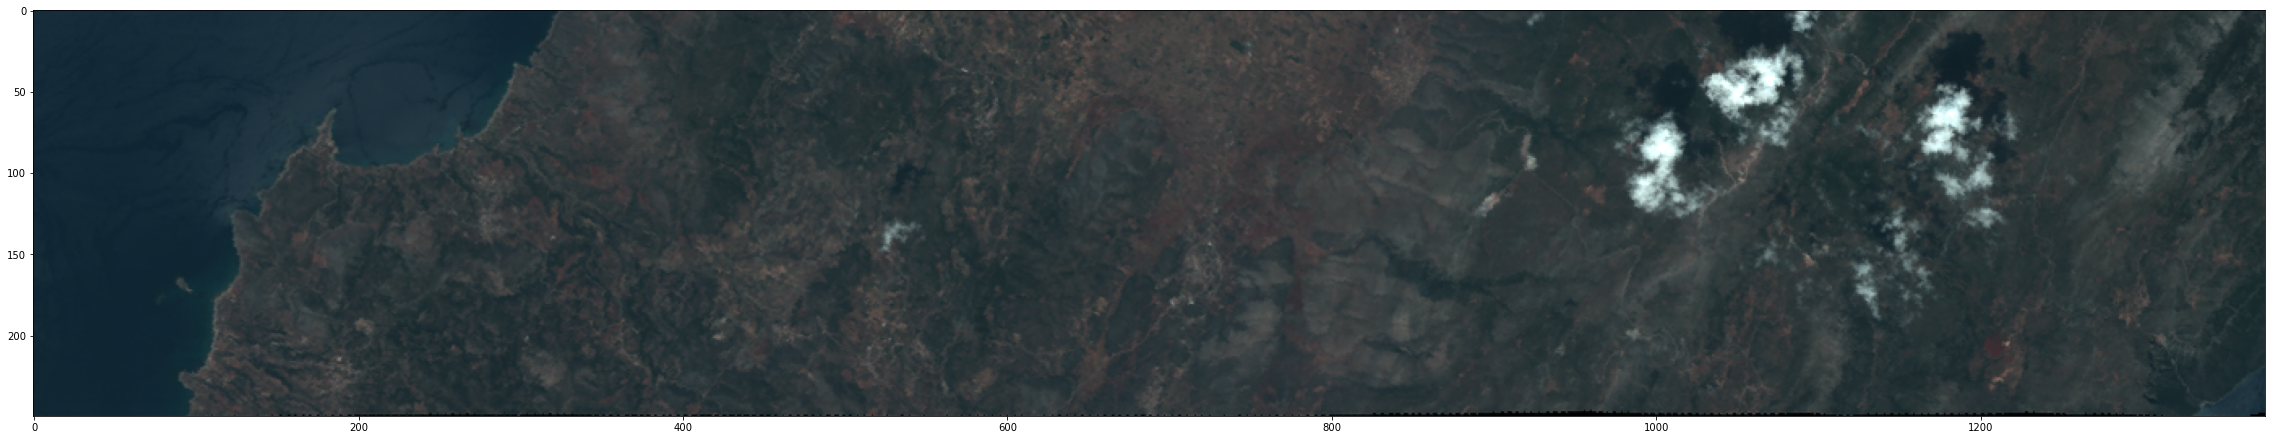

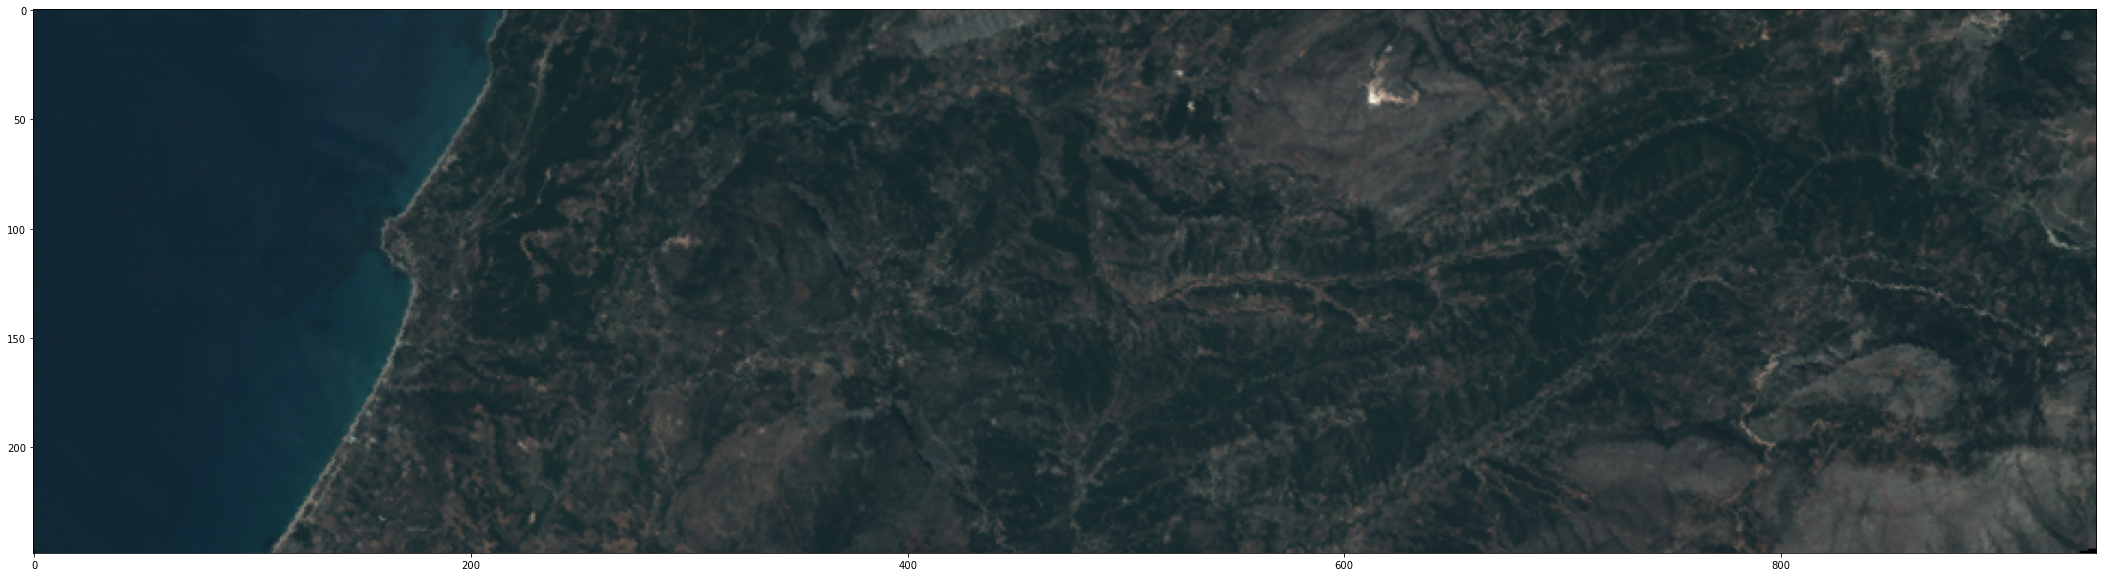

In \[72\]:

    plt.plot(dioni_data[:,1,0])
    dioni_data.shape

Out\[72\]:

    (176, 250, 1376)

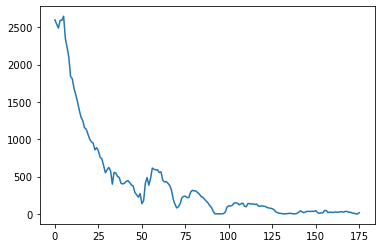

In \[19\]:

    dioni_pixel_data = np.reshape(dioni_data,(176,-1)).T
    dioni_pixel_labels = dioni_labels.flatten()
    print(dioni_pixel_labels.shape)


    loukia_pixel_data = np.reshape(loukia_data,(176,-1)).T
    loukia_pixel_labels = loukia_labels.flatten()
    print(loukia_pixel_labels.shape)

Out\[19\]:

    (235305,)

In \[20\]:

    dioni_pixel_data_cleaned = dioni_pixel_data[dioni_pixel_labels!=0]
    dioni_pixel_labels_cleaned = dioni_pixel_labels[dioni_pixel_labels!=0]
    print(dioni_pixel_labels_cleaned.shape)


    loukia_pixel_data_cleaned = loukia_pixel_data[loukia_pixel_labels!=0]
    loukia_pixel_labels_cleaned = loukia_pixel_labels[loukia_pixel_labels!=0]
    print(loukia_pixel_labels_cleaned.shape)

    (20024,)
    (13503,)

In \[39\]:

    merged_data = np.concatenate((dioni_pixel_data_cleaned,loukia_pixel_data_cleaned),axis=0)
    merged_labels = np.concatenate((dioni_pixel_labels_cleaned,loukia_pixel_labels_cleaned),axis=0)
    pca = PCA(n_components=20)
    pca.fit(merged_data)
    merged_data_trans = pca.transform(merged_data)
    X_train, X_test, y_train, y_test = train_test_split(merged_data_trans, merged_labels, test_size=0.3, random_state=42,stratify=merged_labels)
    rf_clf = RandomForestClassifier(n_jobs=-1)
    rf_clf.fit(X_train, y_train)
    print("Random Forest accuracy : ", rf_clf.score(X_test, y_test), "%")

    Random Forest accuracy :  0.9190774430857939 %

In \[3\]:

    class my_Dataset(Dataset):
        def __init__(self, data, labels, transform=None):
            
            self.data = data
            self.labels = labels

            
            self.transform = transform
            
        def __len__(self):
            # Return the length of the dataset
            return len(self.data)

        def __getitem__(self, idx):
            # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
            if torch.is_tensor(idx):
                idx = idx.tolist()


            patch = self.data[idx]
            patch = np.expand_dims(patch,axis=0)
            label = self.labels[idx] -1

            patch = (patch - means) / stds
            patch = torch.tensor(patch).type(torch.FloatTensor)
            label = torch.tensor(label).type(torch.LongTensor)
            
            if self.transform:
                patch = self.transform(patch)      
        
        
            return (patch, label)

In \[4\]:

    def create_dataset(data_list,labels_list,patch_size):
        x_patches = []
        y_patches = []
        
        for i in range(len(data_list)):
            
            n,x,y = data_list[i].shape
            x_patch = patch_size
            y_patch = patch_size
            x_padding = x_patch//3+1
            y_padding = y_patch//3+1

            x = torch.from_numpy(np.pad(data_list[i],[(0,0),(x_padding, x_padding), (y_padding, y_padding)], mode='constant'))
            y = torch.from_numpy(labels_list[i])

            
            # unfold(dimension, square size, overlapping)
            x = x.unfold(1, x_patch, 1).unfold(2, x_patch, 1)
            x = x.permute(1,2,0,3,4)
            x = x.contiguous().view(-1, 176, x_patch, x_patch)
            
            y = torch.flatten(y)
            
            x = np.delete(x,np.where(y==0),axis=0)
            y = np.delete(y,np.where(y==0),axis=0)
            
            x_patches.append(x)
            y_patches.append(y)
                 
        return np.concatenate((x_patches[0],x_patches[1]),axis=0),np.concatenate((y_patches[0],y_patches[1]))




    data_list = [dioni_data, loukia_data]
    labels_list = [dioni_labels, loukia_labels]
    x,y = create_dataset(data_list, labels_list, 5)

In \[5\]:

    means = list(np.mean(x,axis=(0,2,3)))
    stds = list(np.std(x,axis=(0,2,3)))
    means = np.expand_dims(means,axis=0)
    means = np.expand_dims(means,axis=2)
    means = np.expand_dims(means,axis=3)


    stds = np.expand_dims(stds,axis=0)
    stds = np.expand_dims(stds,axis=2)
    stds = np.expand_dims(stds,axis=3)

In \[6\]:

    # y -= 1
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42,stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42,stratify=y_test)

    batch_size = 16
    train_dataset = my_Dataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

    val_dataset = my_Dataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = my_Dataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In \[7\]:

    # training function
    def train_val(model, epochs = 15):
        
        steps = 0
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []


        train_loss = 0
        train_accuracy = 0

        for epoch in range(epochs):
            kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=epochs, width=8, always_stateful=False)
            batch_num = 0
            for inputs, labels in train_loader:          
                inputs, labels = inputs.to(device), labels.to(device)
                
                logps = model.forward(inputs)
                loss = criterion(logps, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()


                # accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class) == labels.view(*top_class.shape)
                train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                kbar.update(batch_num, values=[("Loss", loss), ("Train accuracy", torch.mean(equals.type(torch.FloatTensor)).item())])

                batch_num += 1

            model.eval()
            val_loss = 0
            val_accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                    logps = model.forward(inputs)

                    batch_loss = criterion(logps, labels)

                    val_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


            kbar.add(1, values=[("Val loss", val_loss/len(val_loader)), ("Val accuracy", val_accuracy/len(val_loader))])

            train_losses.append(train_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))
            train_accuracies.append(train_accuracy/len(train_loader))
            val_accuracies.append(val_accuracy/len(val_loader))

            train_loss = 0
            train_accuracy = 0
            model.train()





        plt.figure(figsize=(14,7))
        plt.plot(train_losses, label='Training loss')
        plt.plot(val_losses, label='Validation loss')
        plt.legend(frameon=False)

        plt.figure(figsize=(14,7))
        plt.plot(train_accuracies, label='Training accuracy')
        plt.plot(val_accuracies, label='Validation accuracy')
        plt.legend(frameon=False)
        
        return

In \[6\]:

    class my_3D_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            
            self.conv1 = nn.Conv3d(1, 16, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
            self.conv2 = nn.Conv3d(16, 32, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
            self.conv3 = nn.Conv3d(32, 64, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
            
            
            self.max1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
            self.max2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
            

            self.dropout = nn.Dropout(0.2)
               
            self.fc1 = nn.Linear(32 * 114 * 1, 14)
        
        def forward(self, x):
            
            # encoder
            x = self.max1(F.relu(self.conv1(x)))
            x = self.max2(F.relu(self.conv2(x)))

            # classifier        
            x = x.view(-1,  32 * 114 * 1 * 1)
            x = self.dropout(x)
            x = F.log_softmax(self.fc1(x), dim=1)
            return x
        
        
    t = my_3D_net()
    summary(t,(16,1,176,5,5))

Out\[6\]:

    ==========================================================================================
    Layer (type:depth-idx)                   Output Shape              Param #
    ==========================================================================================
    my_3D_net                                --                        --
    ├─Conv3d: 1-1                            [16, 16, 145, 5, 5]       4,624
    ├─MaxPool3d: 1-2                         [16, 16, 145, 2, 2]       --
    ├─Conv3d: 1-3                            [16, 32, 114, 2, 2]       147,488
    ├─MaxPool3d: 1-4                         [16, 32, 114, 1, 1]       --
    ├─Dropout: 1-5                           [16, 3648]                --
    ├─Linear: 1-6                            [16, 14]                  51,086
    ==========================================================================================
    Total params: 203,198
    Trainable params: 203,198
    Non-trainable params: 0
    Total mult-adds (G): 1.34
    ==========================================================================================
    Input size (MB): 0.28
    Forward/backward pass size (MB): 9.29
    Params size (MB): 0.81
    Estimated Total Size (MB): 10.39
    ==========================================================================================

In \[9\]:

    my_model = my_3D_net()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    criterion = nn.NLLLoss(ignore_index=-1)

    optimizer = optim.Adam(my_model.parameters(), lr=0.001,weight_decay=0.001)

    my_model.to(device)


    train_val(my_model, 100)

    cuda
    Epoch: 1/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.6406 - Train accuracy: 0.7776 - Val loss: 0.5294 - Val accuracy: 0.8123
    Epoch: 2/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.4569 - Train accuracy: 0.8366 - Val loss: 0.3866 - Val accuracy: 0.8548
    Epoch: 3/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.3903 - Train accuracy: 0.8601 - Val loss: 0.2937 - Val accuracy: 0.8937
    Epoch: 4/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.3351 - Train accuracy: 0.8779 - Val loss: 0.3039 - Val accuracy: 0.8813
    Epoch: 5/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.3270 - Train accuracy: 0.8818 - Val loss: 0.3126 - Val accuracy: 0.8891
    Epoch: 6/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.3154 - Train accuracy: 0.8870 - Val loss: 0.2516 - Val accuracy: 0.9038
    Epoch: 7/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2825 - Train accuracy: 0.8980 - Val loss: 0.2542 - Val accuracy: 0.9035
    Epoch: 8/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2711 - Train accuracy: 0.9009 - Val loss: 0.2502 - Val accuracy: 0.9067
    Epoch: 9/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2615 - Train accuracy: 0.9066 - Val loss: 0.2276 - Val accuracy: 0.9200
    Epoch: 10/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.2550 - Train accuracy: 0.9079 - Val loss: 0.1953 - Val accuracy: 0.9210
    Epoch: 11/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.2276 - Train accuracy: 0.9166 - Val loss: 0.2334 - Val accuracy: 0.9127
    Epoch: 12/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.2461 - Train accuracy: 0.9113 - Val loss: 0.2093 - Val accuracy: 0.9226
    Epoch: 13/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2236 - Train accuracy: 0.9214 - Val loss: 0.1786 - Val accuracy: 0.9286
    Epoch: 14/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2209 - Train accuracy: 0.9228 - Val loss: 0.1881 - Val accuracy: 0.9323
    Epoch: 15/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2211 - Train accuracy: 0.9208 - Val loss: 0.1849 - Val accuracy: 0.9290
    Epoch: 16/100
    1467/1467 [========] - 11s 8ms/step - Loss: 0.2149 - Train accuracy: 0.9234 - Val loss: 0.2895 - Val accuracy: 0.8952
    Epoch: 17/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2179 - Train accuracy: 0.9231 - Val loss: 0.1945 - Val accuracy: 0.9335
    Epoch: 18/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2017 - Train accuracy: 0.9274 - Val loss: 0.1543 - Val accuracy: 0.9398
    Epoch: 19/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2076 - Train accuracy: 0.9282 - Val loss: 0.1556 - Val accuracy: 0.9440
    Epoch: 20/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1954 - Train accuracy: 0.9326 - Val loss: 0.1821 - Val accuracy: 0.9295
    Epoch: 21/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2026 - Train accuracy: 0.9285 - Val loss: 0.1604 - Val accuracy: 0.9440
    Epoch: 22/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1992 - Train accuracy: 0.9287 - Val loss: 0.1860 - Val accuracy: 0.9359
    Epoch: 23/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1864 - Train accuracy: 0.9343 - Val loss: 0.1776 - Val accuracy: 0.9331
    Epoch: 24/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1777 - Train accuracy: 0.9376 - Val loss: 0.2360 - Val accuracy: 0.9200
    Epoch: 25/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1763 - Train accuracy: 0.9371 - Val loss: 0.1357 - Val accuracy: 0.9522
    Epoch: 26/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1850 - Train accuracy: 0.9355 - Val loss: 0.1479 - Val accuracy: 0.9502
    Epoch: 27/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.2339 - Train accuracy: 0.9236 - Val loss: 0.1630 - Val accuracy: 0.9406
    Epoch: 28/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1534 - Train accuracy: 0.9447 - Val loss: 0.1245 - Val accuracy: 0.9546
    Epoch: 29/100
    1467/1467 [========] - 11s 8ms/step - Loss: 0.1710 - Train accuracy: 0.9379 - Val loss: 0.2016 - Val accuracy: 0.9298
    Epoch: 30/100
    1467/1467 [========] - 11s 8ms/step - Loss: 0.1748 - Train accuracy: 0.9385 - Val loss: 0.1499 - Val accuracy: 0.9482
    Epoch: 31/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1630 - Train accuracy: 0.9412 - Val loss: 0.1585 - Val accuracy: 0.9427
    Epoch: 32/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1742 - Train accuracy: 0.9397 - Val loss: 0.1879 - Val accuracy: 0.9333
    Epoch: 33/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1782 - Train accuracy: 0.9392 - Val loss: 0.1455 - Val accuracy: 0.9502
    Epoch: 34/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1621 - Train accuracy: 0.9435 - Val loss: 0.1414 - Val accuracy: 0.9508
    Epoch: 35/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1632 - Train accuracy: 0.9439 - Val loss: 0.2110 - Val accuracy: 0.9230
    Epoch: 36/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1796 - Train accuracy: 0.9407 - Val loss: 0.1658 - Val accuracy: 0.9490
    Epoch: 37/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1499 - Train accuracy: 0.9467 - Val loss: 0.1537 - Val accuracy: 0.9468
    Epoch: 38/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1643 - Train accuracy: 0.9427 - Val loss: 0.2077 - Val accuracy: 0.9341
    Epoch: 39/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1553 - Train accuracy: 0.9453 - Val loss: 0.1880 - Val accuracy: 0.9359
    Epoch: 40/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1534 - Train accuracy: 0.9472 - Val loss: 0.1334 - Val accuracy: 0.9560
    Epoch: 41/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1546 - Train accuracy: 0.9451 - Val loss: 0.1177 - Val accuracy: 0.9595
    Epoch: 42/100
    1467/1467 [========] - 12s 9ms/step - Loss: 0.1541 - Train accuracy: 0.9487 - Val loss: 0.1318 - Val accuracy: 0.9528
    Epoch: 43/100
    1467/1467 [========] - 14s 10ms/step - Loss: 0.1432 - Train accuracy: 0.9492 - Val loss: 0.1393 - Val accuracy: 0.9492
    Epoch: 44/100
    1467/1467 [========] - 14s 9ms/step - Loss: 0.1493 - Train accuracy: 0.9498 - Val loss: 0.1587 - Val accuracy: 0.9444
    Epoch: 45/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1482 - Train accuracy: 0.9467 - Val loss: 0.1693 - Val accuracy: 0.9440
    Epoch: 46/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1666 - Train accuracy: 0.9443 - Val loss: 0.1341 - Val accuracy: 0.9508
    Epoch: 47/100
    1467/1467 [========] - 14s 9ms/step - Loss: 0.1965 - Train accuracy: 0.9362 - Val loss: 0.1334 - Val accuracy: 0.9524
    Epoch: 48/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1392 - Train accuracy: 0.9517 - Val loss: 0.1266 - Val accuracy: 0.9546
    Epoch: 49/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1501 - Train accuracy: 0.9485 - Val loss: 0.1305 - Val accuracy: 0.9556
    Epoch: 50/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1327 - Train accuracy: 0.9542 - Val loss: 0.1219 - Val accuracy: 0.9565
    Epoch: 51/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1476 - Train accuracy: 0.9495 - Val loss: 0.1184 - Val accuracy: 0.9593
    Epoch: 52/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1419 - Train accuracy: 0.9497 - Val loss: 0.1436 - Val accuracy: 0.9542
    Epoch: 53/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1338 - Train accuracy: 0.9531 - Val loss: 0.1507 - Val accuracy: 0.9448
    Epoch: 54/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1505 - Train accuracy: 0.9480 - Val loss: 0.1272 - Val accuracy: 0.9534
    Epoch: 55/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1398 - Train accuracy: 0.9510 - Val loss: 0.1269 - Val accuracy: 0.9558
    Epoch: 56/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1403 - Train accuracy: 0.9512 - Val loss: 0.1225 - Val accuracy: 0.9573
    Epoch: 57/100
    1467/1467 [========] - 12s 9ms/step - Loss: 0.1228 - Train accuracy: 0.9575 - Val loss: 0.1587 - Val accuracy: 0.9427
    Epoch: 58/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1358 - Train accuracy: 0.9533 - Val loss: 0.1298 - Val accuracy: 0.9538
    Epoch: 59/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1368 - Train accuracy: 0.9530 - Val loss: 0.1362 - Val accuracy: 0.9526
    Epoch: 60/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.2905 - Train accuracy: 0.9172 - Val loss: 0.2271 - Val accuracy: 0.9254
    Epoch: 61/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1174 - Train accuracy: 0.9569 - Val loss: 0.1133 - Val accuracy: 0.9623
    Epoch: 62/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1814 - Train accuracy: 0.9402 - Val loss: 0.1227 - Val accuracy: 0.9575
    Epoch: 63/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1141 - Train accuracy: 0.9592 - Val loss: 0.1160 - Val accuracy: 0.9583
    Epoch: 64/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1251 - Train accuracy: 0.9555 - Val loss: 0.1179 - Val accuracy: 0.9571
    Epoch: 65/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1305 - Train accuracy: 0.9540 - Val loss: 0.1178 - Val accuracy: 0.9591
    Epoch: 66/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1377 - Train accuracy: 0.9523 - Val loss: 0.1333 - Val accuracy: 0.9516
    Epoch: 67/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1190 - Train accuracy: 0.9577 - Val loss: 0.1164 - Val accuracy: 0.9575
    Epoch: 68/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1273 - Train accuracy: 0.9570 - Val loss: 0.1177 - Val accuracy: 0.9579
    Epoch: 69/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1303 - Train accuracy: 0.9545 - Val loss: 0.1255 - Val accuracy: 0.9554
    Epoch: 70/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1312 - Train accuracy: 0.9545 - Val loss: 0.1107 - Val accuracy: 0.9583
    Epoch: 71/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1334 - Train accuracy: 0.9550 - Val loss: 0.1149 - Val accuracy: 0.9617
    Epoch: 72/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1268 - Train accuracy: 0.9560 - Val loss: 0.1219 - Val accuracy: 0.9567
    Epoch: 73/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1190 - Train accuracy: 0.9569 - Val loss: 0.1384 - Val accuracy: 0.9506
    Epoch: 74/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1210 - Train accuracy: 0.9582 - Val loss: 0.1328 - Val accuracy: 0.9514
    Epoch: 75/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1542 - Train accuracy: 0.9473 - Val loss: 0.1095 - Val accuracy: 0.9646
    Epoch: 76/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1162 - Train accuracy: 0.9586 - Val loss: 0.1249 - Val accuracy: 0.9569
    Epoch: 77/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1704 - Train accuracy: 0.9453 - Val loss: 0.0984 - Val accuracy: 0.9679
    Epoch: 78/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1158 - Train accuracy: 0.9590 - Val loss: 0.1319 - Val accuracy: 0.9575
    Epoch: 79/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1268 - Train accuracy: 0.9556 - Val loss: 0.1281 - Val accuracy: 0.9559
    Epoch: 80/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1133 - Train accuracy: 0.9599 - Val loss: 0.1219 - Val accuracy: 0.9575
    Epoch: 81/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1325 - Train accuracy: 0.9545 - Val loss: 0.1276 - Val accuracy: 0.9554
    Epoch: 82/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1214 - Train accuracy: 0.9594 - Val loss: 0.1334 - Val accuracy: 0.9504
    Epoch: 83/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1200 - Train accuracy: 0.9573 - Val loss: 0.1229 - Val accuracy: 0.9587
    Epoch: 84/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1429 - Train accuracy: 0.9533 - Val loss: 0.1178 - Val accuracy: 0.9565
    Epoch: 85/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1241 - Train accuracy: 0.9574 - Val loss: 0.1380 - Val accuracy: 0.9462
    Epoch: 86/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1155 - Train accuracy: 0.9600 - Val loss: 0.1251 - Val accuracy: 0.9571
    Epoch: 87/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1249 - Train accuracy: 0.9555 - Val loss: 0.1468 - Val accuracy: 0.9476
    Epoch: 88/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1691 - Train accuracy: 0.9486 - Val loss: 0.0961 - Val accuracy: 0.9685
    Epoch: 89/100
    1467/1467 [========] - 12s 8ms/step - Loss: 0.1141 - Train accuracy: 0.9590 - Val loss: 0.1027 - Val accuracy: 0.9655
    Epoch: 90/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1146 - Train accuracy: 0.9614 - Val loss: 0.1722 - Val accuracy: 0.9431
    Epoch: 91/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1212 - Train accuracy: 0.9581 - Val loss: 0.1543 - Val accuracy: 0.9510
    Epoch: 92/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1561 - Train accuracy: 0.9509 - Val loss: 0.1114 - Val accuracy: 0.9601
    Epoch: 93/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1072 - Train accuracy: 0.9605 - Val loss: 0.1378 - Val accuracy: 0.9515
    Epoch: 94/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1195 - Train accuracy: 0.9572 - Val loss: 0.1129 - Val accuracy: 0.9607
    Epoch: 95/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1107 - Train accuracy: 0.9601 - Val loss: 0.1226 - Val accuracy: 0.9575
    Epoch: 96/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1141 - Train accuracy: 0.9606 - Val loss: 0.0930 - Val accuracy: 0.9669
    Epoch: 97/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1108 - Train accuracy: 0.9608 - Val loss: 0.1398 - Val accuracy: 0.9496
    Epoch: 98/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1394 - Train accuracy: 0.9526 - Val loss: 0.1869 - Val accuracy: 0.9337
    Epoch: 99/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1271 - Train accuracy: 0.9574 - Val loss: 0.1342 - Val accuracy: 0.9552
    Epoch: 100/100
    1467/1467 [========] - 13s 9ms/step - Loss: 0.1111 - Train accuracy: 0.9615 - Val loss: 0.1002 - Val accuracy: 0.9645

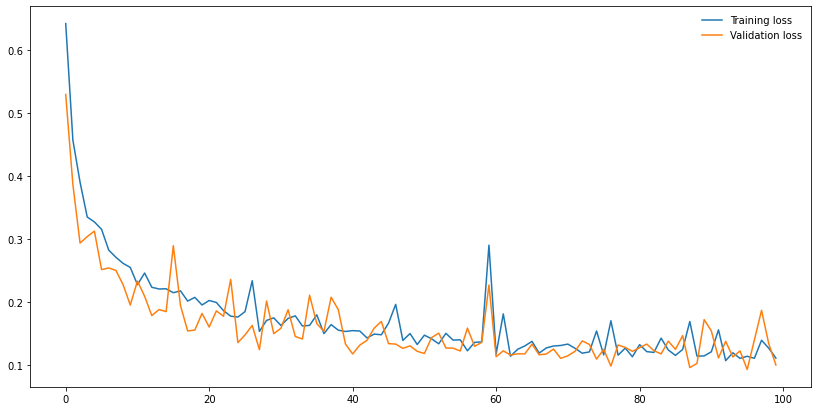

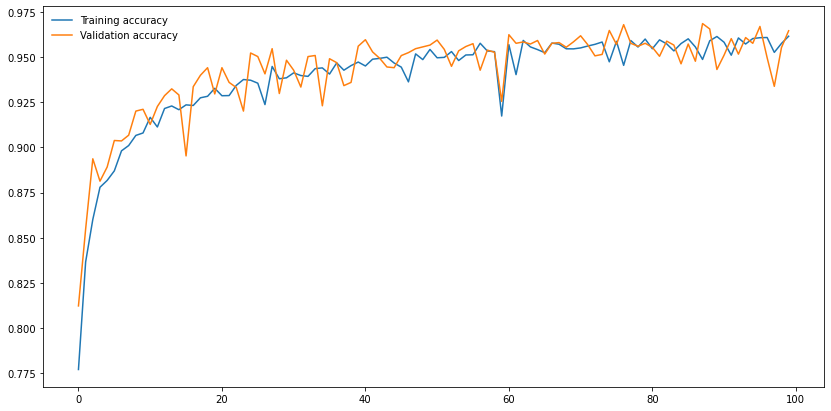

In \[10\]:

    # test and results function
    label_names = ["DenseUrban",
                   "MineralExtr",
                   "NonIrrigated",
                   "Fruit",
                   "Olive",
                   "BroadForest",
                   "ConiferousForest",
                   "MixedForest",
                   "DenseScleroph",
                   "SparceScleroph",
                   "SparcelyVeget",
                   "RocksSand",
                   "Water",
                   "CoastalWater"]
    def test_results(model):
        tot_test_loss = 0
        test_correct = 0  
        all_predictions = []
        all_labels = []


        with torch.no_grad():
            model.eval()
            for inputs, labels in test_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                log_ps = model(inputs)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps).cpu()
                top_p, top_class = ps.topk(1, dim=1)
                top_p, top_class =top_p.cpu(), top_class.cpu()
                all_predictions.append(list(top_class.numpy().squeeze()))
                all_labels.append(list(labels.cpu().cpu().numpy().squeeze()))
                equals = top_class == labels.cpu().view(*top_class.shape)
                test_correct += equals.sum().item()

                test_loss = tot_test_loss / len(test_loader.dataset)

        print("Test Loss: {:.3f}.. ".format(test_loss),"Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset)))

        pred_list = [item for sublist in all_predictions for item in sublist]
        labels_list = [item for sublist in all_labels for item in sublist]

        prec, rec, f1, sup = precision_recall_fscore_support(labels_list, pred_list)

        print("Precision :", prec)
        print("Recall :", rec)
        print("F1 Score :", f1)



        prec_weighted, rec_weighted, f1_weighted, sup_weighted = precision_recall_fscore_support(labels_list, pred_list,average='weighted')

        print("Precision weighted:", prec_weighted)
        print("Recall weighted:", rec_weighted)
        print("F1 Score weighted:", f1_weighted)

        cm=confusion_matrix(labels_list,pred_list)

        df_cm = pd.DataFrame(cm, index = range(1,15),
                          columns = range(1,15))
        plt.figure(figsize = (16,13)) 
        sn.heatmap(df_cm, annot=True,fmt='d',yticklabels=label_names,xticklabels=label_names)
        t = plt.yticks(rotation=0)
        t = plt.xticks(rotation=45)

        return

In \[11\]:

    test_results(my_model)

    Test Loss: 0.006..  Test Accuracy: 0.969
    Precision : [0.96412556 1.         0.9760479  0.92307692 0.94845361 0.92592593
     0.92913386 0.91025641 0.96008869 0.98029197 0.98165138 0.97333333
     0.99339207 1.        ]
    Recall : [0.92274678 1.         0.94219653 0.70588235 0.96638655 0.75757576
     0.91472868 0.88198758 0.98037736 0.97530864 0.99074074 0.99319728
     1.         0.98425197]
    F1 Score : [0.94298246 1.         0.95882353 0.8        0.95733611 0.83333333
     0.921875   0.89589905 0.97012696 0.97779396 0.98617512 0.98316498
     0.99668508 0.99206349]
    Precision weighted: 0.9684782527534255
    Recall weighted: 0.9685884691848906
    F1 Score weighted: 0.9682959284572583

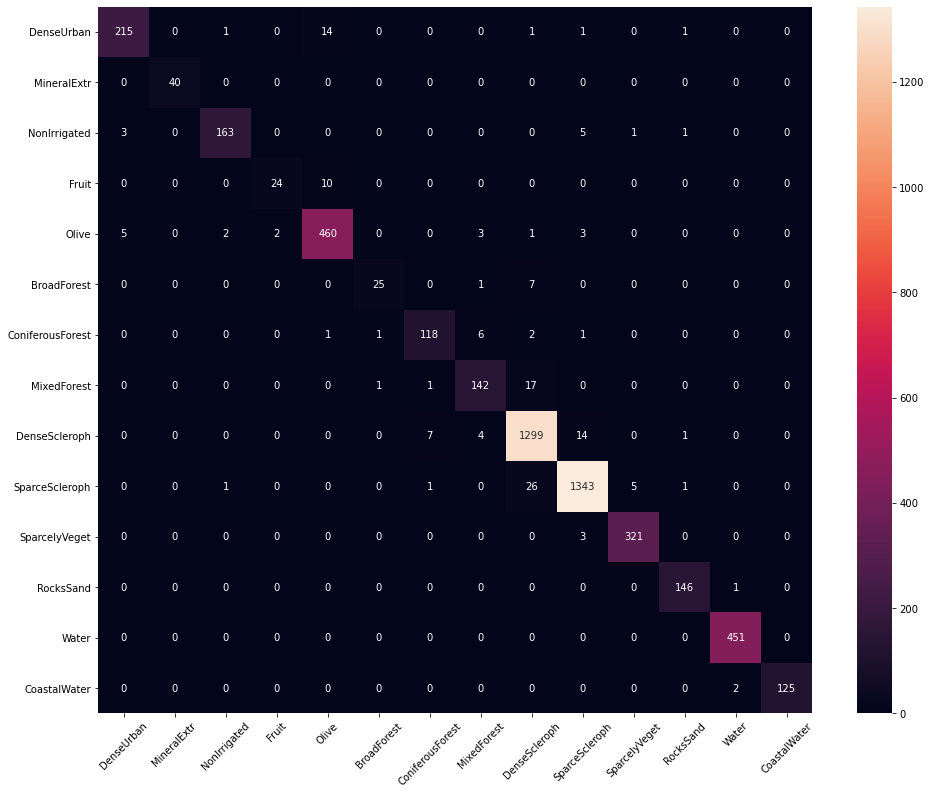

In \[ \]:

     

# Validation Set to deliver<a href="#Validation-Set-to-deliver" class="anchor-link">¶</a>

In \[15\]:

    selected_set = 2

    test_data_paths = [
        "./HyRANK_satellite/ValidationSet/Erato.tif",
        "./HyRANK_satellite/ValidationSet/Kirki.tif",
        "./HyRANK_satellite/ValidationSet/Nefeli.tif"
    ]

    test_names = [
        "erato",
        "kirki",
        "nefeli"
    ]


    data = rs.open(test_data_paths[selected_set]).read()

    shape = data.shape

In \[16\]:

    class my_test_Dataset(Dataset):
        def __init__(self, data, transform=None):     
            self.data = data
            self.transform = transform
            
        def __len__(self):
            # Return the length of the dataset
            return len(self.data)

        def __getitem__(self, idx):
            # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
            if torch.is_tensor(idx):
                idx = idx.tolist()

            patch = self.data[idx]
            patch = np.expand_dims(patch,axis=0)

            if self.transform:
                patch = self.transform(patch)
                
            patch = (patch - means) / stds
            
            patch = torch.tensor(patch).type(torch.FloatTensor)
            
            return (patch)

In \[17\]:

    def create_test_dataset(data,patch_size):
    #     x_patches = []
        

        n,x,y = data.shape
        x_patch = patch_size
        y_patch = patch_size
        x_padding = x_patch//3+1
        y_padding = y_patch//3+1

        data = torch.from_numpy(np.pad(data,[(0,0),(x_padding, x_padding), (y_padding, y_padding)], mode='constant'))

        # unfold(dimension, square size, overlapping)
        data = data.unfold(1, x_patch, 1).unfold(2, x_patch, 1)
        data = data.permute(1,2,0,3,4)
        data = data.contiguous().view(-1, 176, x_patch, x_patch)

        return data


    x = create_test_dataset(data, 5).type(torch.HalfTensor) 

    x.shape

Out\[17\]:

    torch.Size([192228, 176, 5, 5])

In \[18\]:

    batch_size = 64
    test_dataset = my_test_Dataset(x)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In \[19\]:

    # test and results function
    def test_results(model):
        all_predictions = []

        i=0
        with torch.no_grad():
            model.eval()
            for inputs in test_loader:

                inputs = inputs.to(device)

                log_ps = model(inputs)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                top_p, top_class =top_p, top_class
                all_predictions.append(top_class.cpu().numpy())
                i+=1
                
                if (i%200==0):
                    print(i)
                
                
        return all_predictions

In \[20\]:

    # save trained model
    # torch.save(my_model.state_dict(), "./my_model_state")

    # load trained model
    # my_model = my_3D_net()
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # my_model.to(device)
    # my_model.load_state_dict(torch.load("./my_model_state"))

Out\[20\]:

    <All keys matched successfully>

In \[21\]:

    res = test_results(my_model)

    200
    400
    600
    800
    1000
    1200
    1400
    1600
    1800
    2000
    2200
    2400
    2600
    2800
    3000

In \[24\]:

    t = np.concatenate(res)
    print(t.shape)
    image = np.reshape(t,shape[1:]) + 1
    image.shape

    plt.figure(figsize=(40,15))
    plot.show(image)
    plt.savefig(test_names[selected_set] + "_results.png")

    im = Image.fromarray(image.astype('uint8'))
    im.save(test_names[selected_set] + "_results.tif")

    (192228, 1)

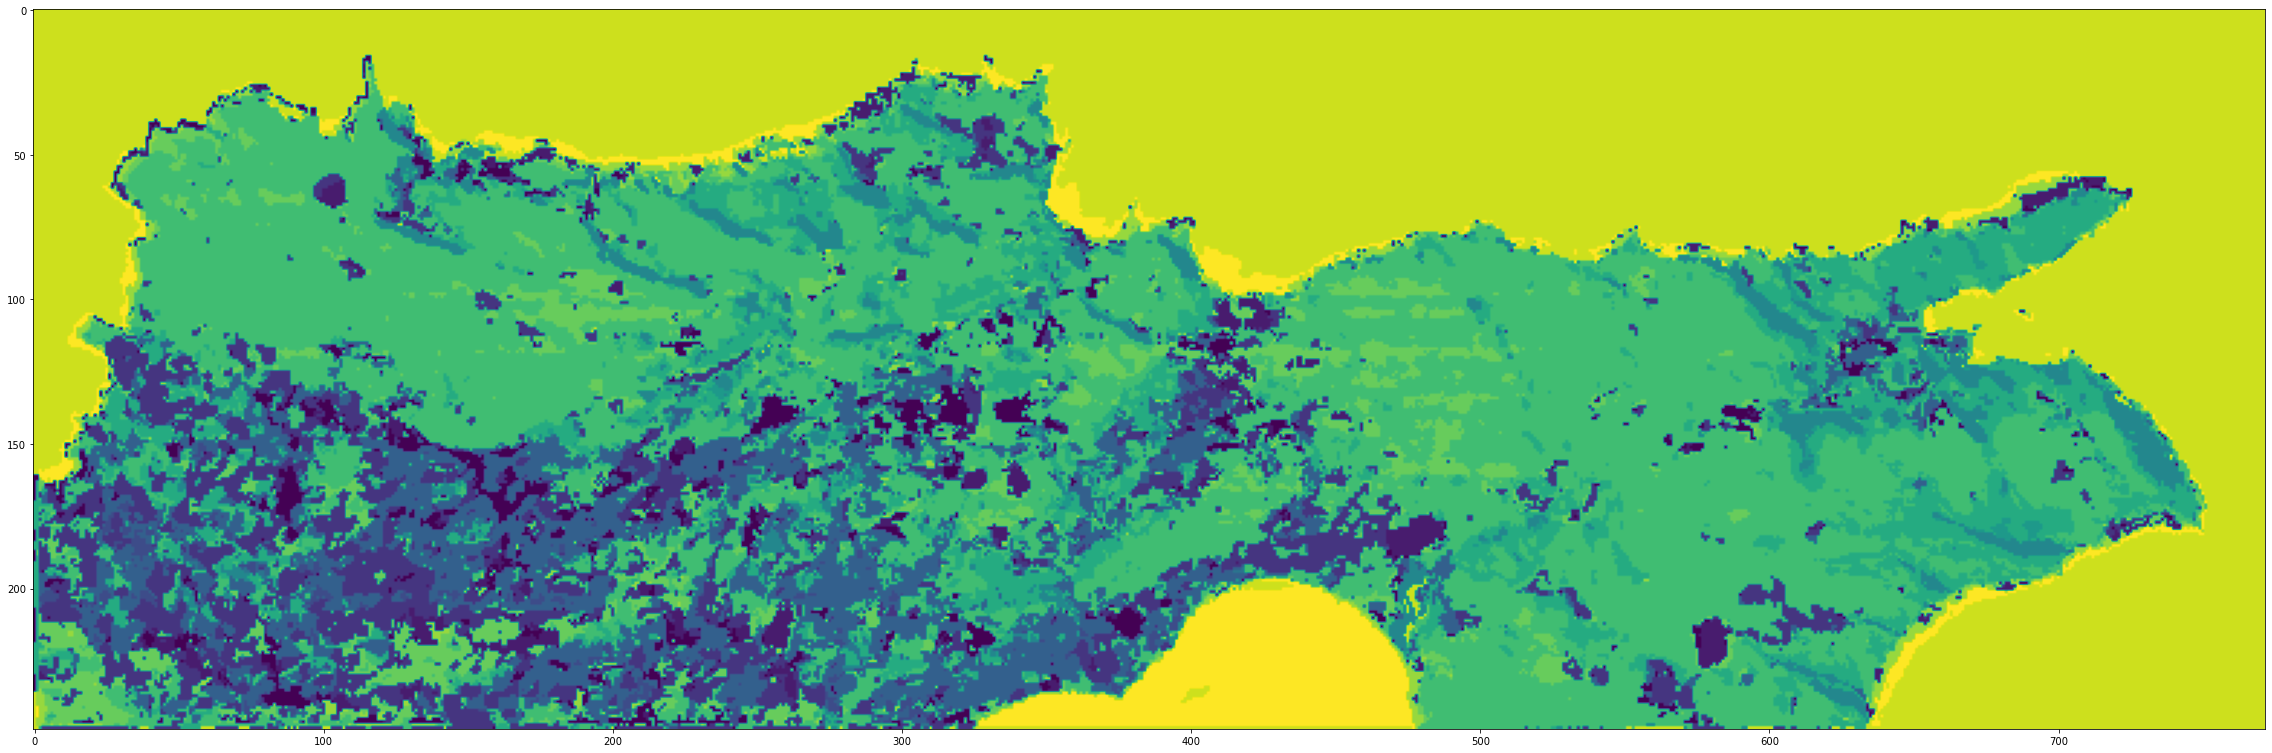

    <Figure size 432x288 with 0 Axes>

In \[ \]: